In [165]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

Зробити (або знайти) декілька зображень будь-якого об'єкта на однорідному фоні з рівномірним освітленням. А також зображення фону. Обрізати зображення через "NumPy Array Slicing" Конвертувати зображення в чб варіант. Застосувати метод Отсу для знаходження порогу глобальної бінаризації. Створити бінарну маску об'єкта на зображенні. За допомогою отриманої маски, вирізати лише об’єкт з оригінального ображення та додати його на зображення фону. Завантажити роботу (код, вхідні зображення та результат) на свій гітхаб. Посилання на репозиторій а також файл з кодом (.py.ipynb.ccp etc.) додати в Google Classroom (для звітності).

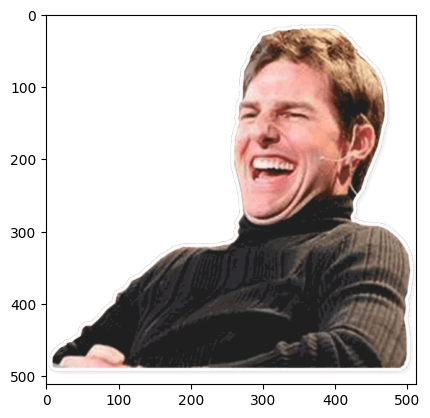

In [166]:
img1_path = 'imgs/mem11.png'
img2_path = 'imgs/fed.jpg'

img1_raw = plt.imread(img1_path)
img2_raw = plt.imread(img2_path)

plt.imshow(img1_raw)

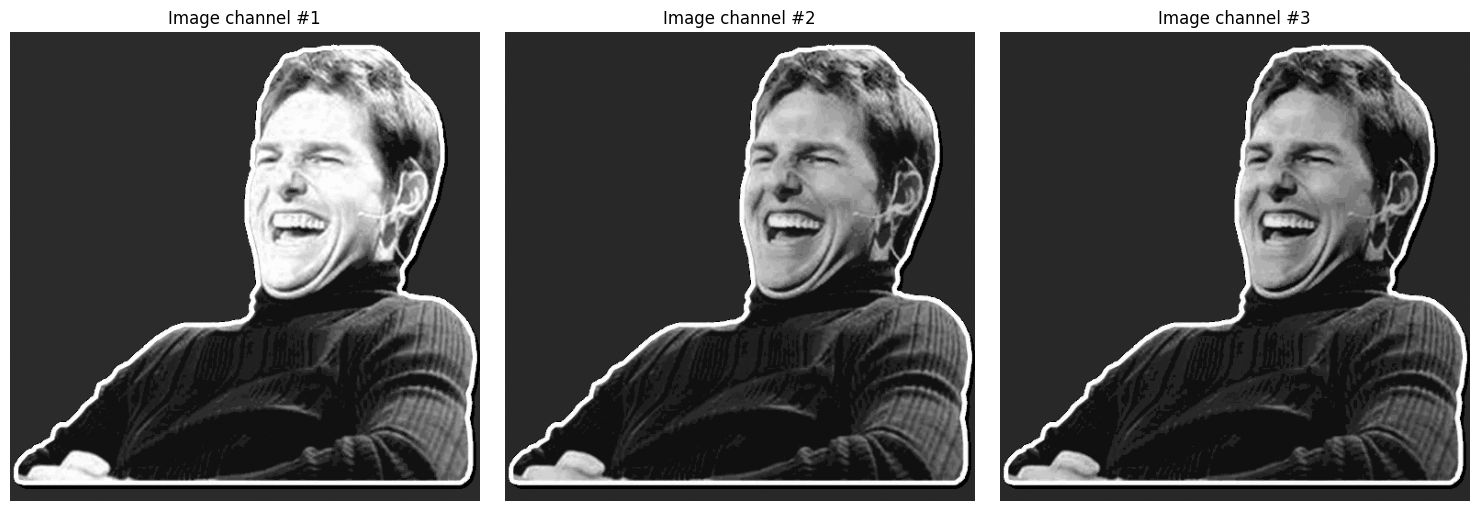

In [167]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(img1_raw[:, :, i], cmap='gray')
    axes[i].set_title(f'Image channel #{i+1}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

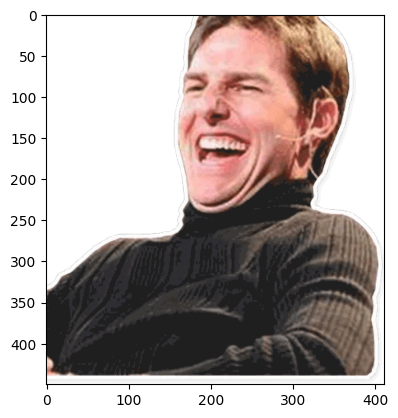

In [168]:
### Crop the image
img1 = img1_raw[50:500, 100:550, :]
plt.imshow(img1, cmap='gray')

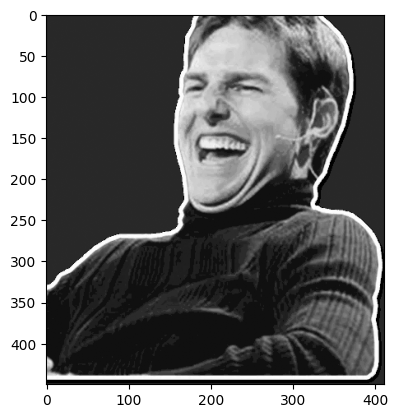

In [169]:
img_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img_gray = (img_gray * 255).astype(np.uint8)
plt.imshow(img_gray, cmap = "gray")

In [170]:
print(img_gray.min(), img_gray.max(), img_gray.dtype)


16 254 uint8


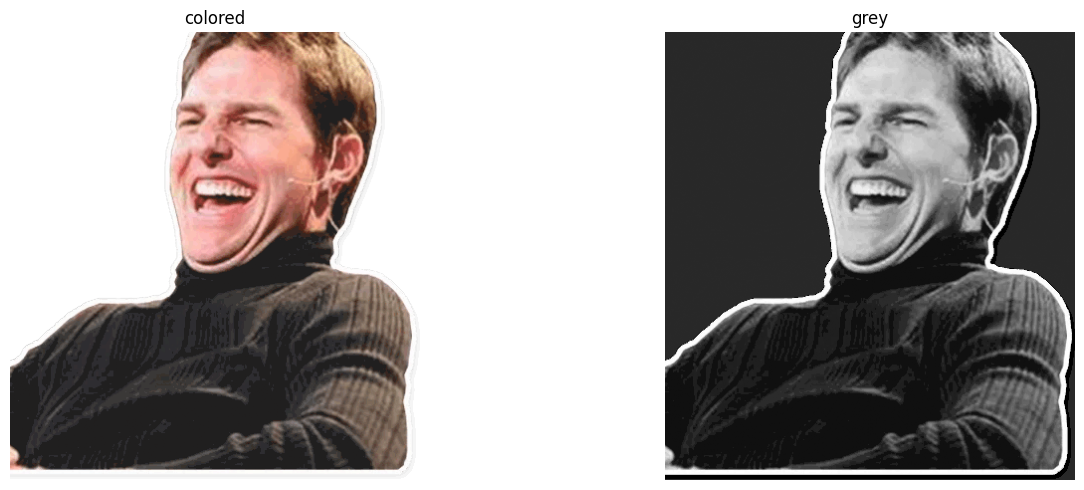

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title("colored")

axes[1].imshow(img_gray, cmap='gray')
axes[1].axis('off')
axes[1].set_title("grey")

plt.tight_layout()
plt.show()

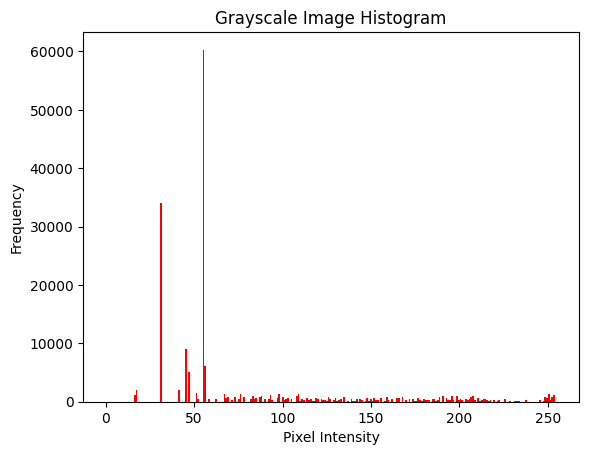

In [172]:
plt.hist(img_gray.ravel(), bins=256, range=(0, 255), color='red')
plt.title('Grayscale Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


In [5]:
def otsu_threshold(img_gray): 
    hist, bins = np.histogram(img_gray.ravel(), bins=256, range=(0, 256))
    hist = hist.astype(np.float32) / hist.sum() 

    best_thresh = 0
    max_between_var = 0
    
    global_mean = np.sum(np.arange(256) * hist)

    for t in range(256):
        w0 = hist[:t].sum()
        w1 = hist[t:].sum()
        if w0 == 0 or w1 == 0:
            continue

        u0 = np.sum(np.arange(0, t) * hist[:t]) / w0
        μ1 = np.sum(np.arange(t, 256) * hist[t:]) / w1

        between_var = w0 * w1 * (μ0 - μ1) ** 2

        if between_var > max_between_var:
            max_between_var = between_var
            best_thresh = t

    return best_thresh

def binarization_global(img_gray, threshold): 
    return (img_gray > threshold).astype(np.uint8) * 255



(450, 412) uint8


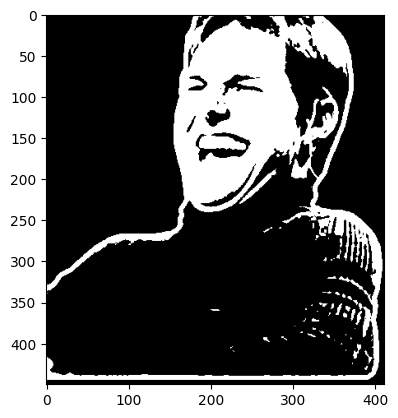

In [174]:
img_mask = binarization_global(img_gray, threshold=otsu_t)
#Біле (255) = Людина, Чорне (0) = Фон
print(img_mask.shape, img_mask.dtype)
plt.imshow(img_mask, cmap='gray')

(450, 412, 4) float32
0.0 1.0
0.0 1.0


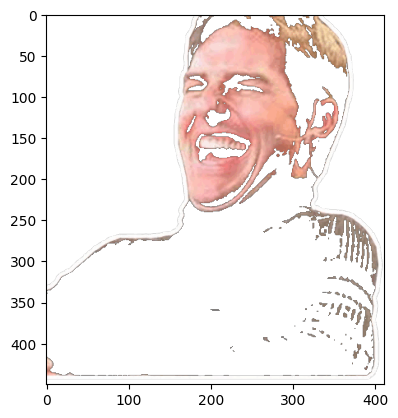

In [175]:
img_separate = np.zeros_like(img1)
img_separate = img1 * (img_mask[:, :, None] >0)
plt.imshow(img_separate)
print(img_separate.shape, img_separate.dtype)
print(np.min(img1), np.max(img1))
print(np.min(img_separate), np.max(img_separate))

(693, 1280, 3) uint8


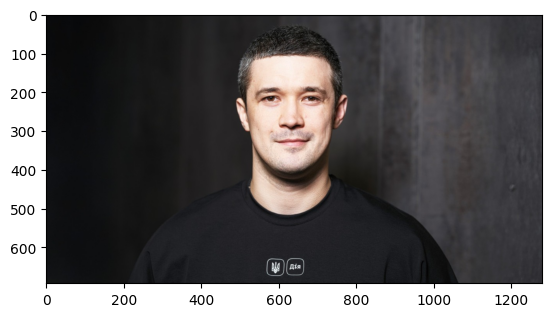

In [176]:
plt.imshow(img2_raw)
print(img2_raw.shape, img2_raw.dtype)

In [ ]:


def compose(bg_img: np.ndarray, fg_img: np.ndarray, mask: np.ndarray, y_pos: int, x_pos: int) -> np.ndarray:
    
    h_fg, w_fg, _ = fg_img.shape
    h_bg, w_bg, _ = bg_img.shape

    result = bg_img.copy()

    y_end = min(y_pos + h_fg, h_bg)
    x_end = min(x_pos + w_fg, w_bg)

    y_slice = slice(y_pos, y_end)
    x_slice = slice(x_pos, x_end)

    h_fit = y_end - y_pos
    w_fit = x_end - x_pos

    bg_patch = result[y_slice, x_slice].astype(np.float32) / 255.0
    fg_patch = fg_img[:h_fit, :w_fit].astype(np.float32) / 255.0 
    mask_patch = mask[:h_fit, :w_fit].astype(np.float32) / 255.0 

    if mask_patch.ndim == 2:
        mask_patch = np.expand_dims(mask_patch, axis=-1)

    # Формуємо складене зображення: fg * mask + bg * (1 - mask)
    composed_patch = fg_patch * mask_patch + bg_patch * (1.0 - mask_patch)

    # Повертаємо в uint8 [0, 255]
    result[y_slice, x_slice] = (composed_patch * 255).astype(bg_img.dtype)
    return result



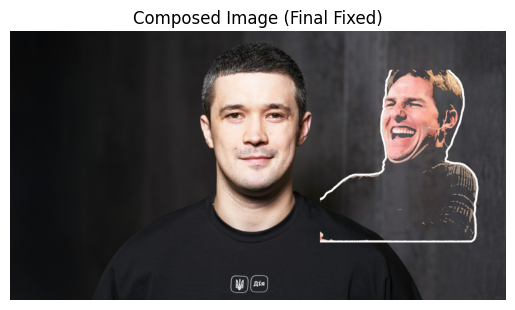

In [ ]:

img1_rgb_uint8 = (img1 * 255).astype(np.uint8)[:, :, :3]

x, y = 800, 100
# Використовуємо 3-канальний передній план
img_res = compose(img2_raw, img1_rgb_uint8, img_mask, y, x)

plt.imshow(img_res)
plt.axis('off')
plt.title("Composed Image (Final Fixed)")
plt.show()